# Variational Quantum Eigensolving on Quantum Spin Liquids

#### By: Kevin Lie-Atjam

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ
import numpy as np
from qiskit.providers.fake_provider import FakeGuadalupe
from time import time
import rustworkx as rx
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit_nature.problems.second_quantization.lattice import Lattice
from heisenberg_model import HeisenbergModel

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [3]:
IBMQ.load_account() # Load account from disk

# Noisy simulator backend
noisy_sim = FakeGuadalupe()

We will then set up our lattice that we will be working with which is a Kagome Lattice. The computer we are working on if IBM's Guadalupe computer which contains 16 qubits. 

![Alt text](Images/Guadalupe_Topology.png)

We only need 12 to compute over our lattice. We will neglect 4 qubits: 0, 3, 6, and 15 to make the layout as similar to the Kagome lattice as possible. We have included nodes 12, 13, 14, and 15 outside of the lattice to denote that they are unused.

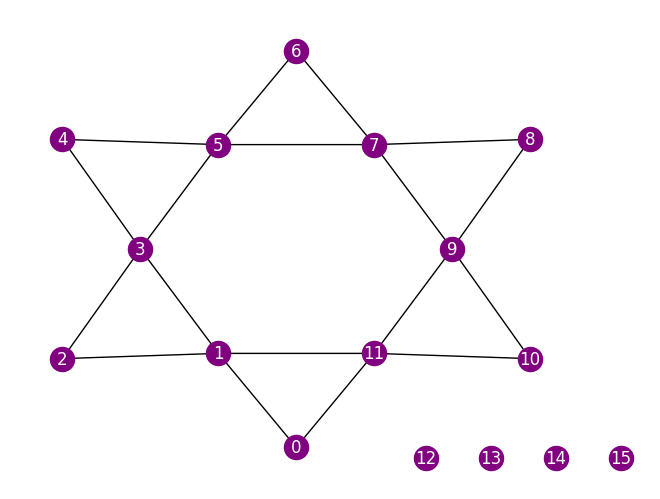

In [4]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_12 = rx.PyGraph(multigraph=False)
graph_12.add_nodes_from(range(num_qubits))
edge_list = [
    (0, 1, t),
    (0, 11, t),
    (1, 11, t),
    (1, 2, t),
    (1, 3, t),
    (2, 3, t),
    (3, 4, t),
    (3, 5, t),
    (4, 5, t),
    (5, 6, t),
    (5, 7, t),
    (6, 7, t),
    (7, 8, t),
    (7, 9, t),
    (8, 9, t),
    (9, 10, t),
    (9, 11, t),
    (10, 11, t),
]
# Generate graph from the list of edges
graph_12.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_12 = Lattice(graph_12)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations

kagome_pos = {12:[1,-1], 13:[1.5,-1], 14:[2,-1], 15:[2.5,-1],
              0:[0,-0.8], 1:[-0.6,1], 11:[0.6,1], 9:[1.2,3], 
              7:[0.6,5], 5:[-0.6,5], 3:[-1.2,3], 2:[-1.8,0.9], 
              4:[-1.8,5.1], 6:[0,6.8], 10:[1.8,0.9], 8:[1.8,5.1]}
kagome_unit_cell_12.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

We then need to create our Hamiltonian matrix and map each of the electron spins to each of the nodes in accordance to the matrix. The Hamiltonian is based off of the Ising Model on the material Herbertsmithite which has a ground state level of -10.2 MeV. The Ising Model has been created by IBM in the file heisenberg_model.py.

In [5]:
# Build Hamiltonian from graph edges
heis_12 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_12,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_12 = 4 * log_mapper.map(heis_12.second_q_ops().simplify())

With the Ansatz, we are going to want to model the behavior of how a spin liquid would act under a certain condition. Say that qubit 0 is placed into a quantum state where the spin is both up and down. That will cause the qubits 1 and 11 to alter their spin orientations to ensure that the spin pairs are not the same. However, since 0 is in a quantum state, qubits 1 and 11 are also likely to be placed into a quantum state which will also affect qubits 2, 3, 9, and 10 additionally. We can represent the path that the quantum spin state will take by traversing through the lattice starting at qubit 0.

![Alt text](Images/1.png)
![Alt text](Images/2.png)
![Alt text](Images/3.png)
![Alt text](Images/4.png)
![Alt text](Images/5.png)
![Alt text](Images/6.png)
![Alt text](Images/7.png)

A purple node represents an unaffected electron in the lattice while an orange node represents an electron that is in its quantum spin state

Now it's time to create our Ansatz of the system which has been outlined below.

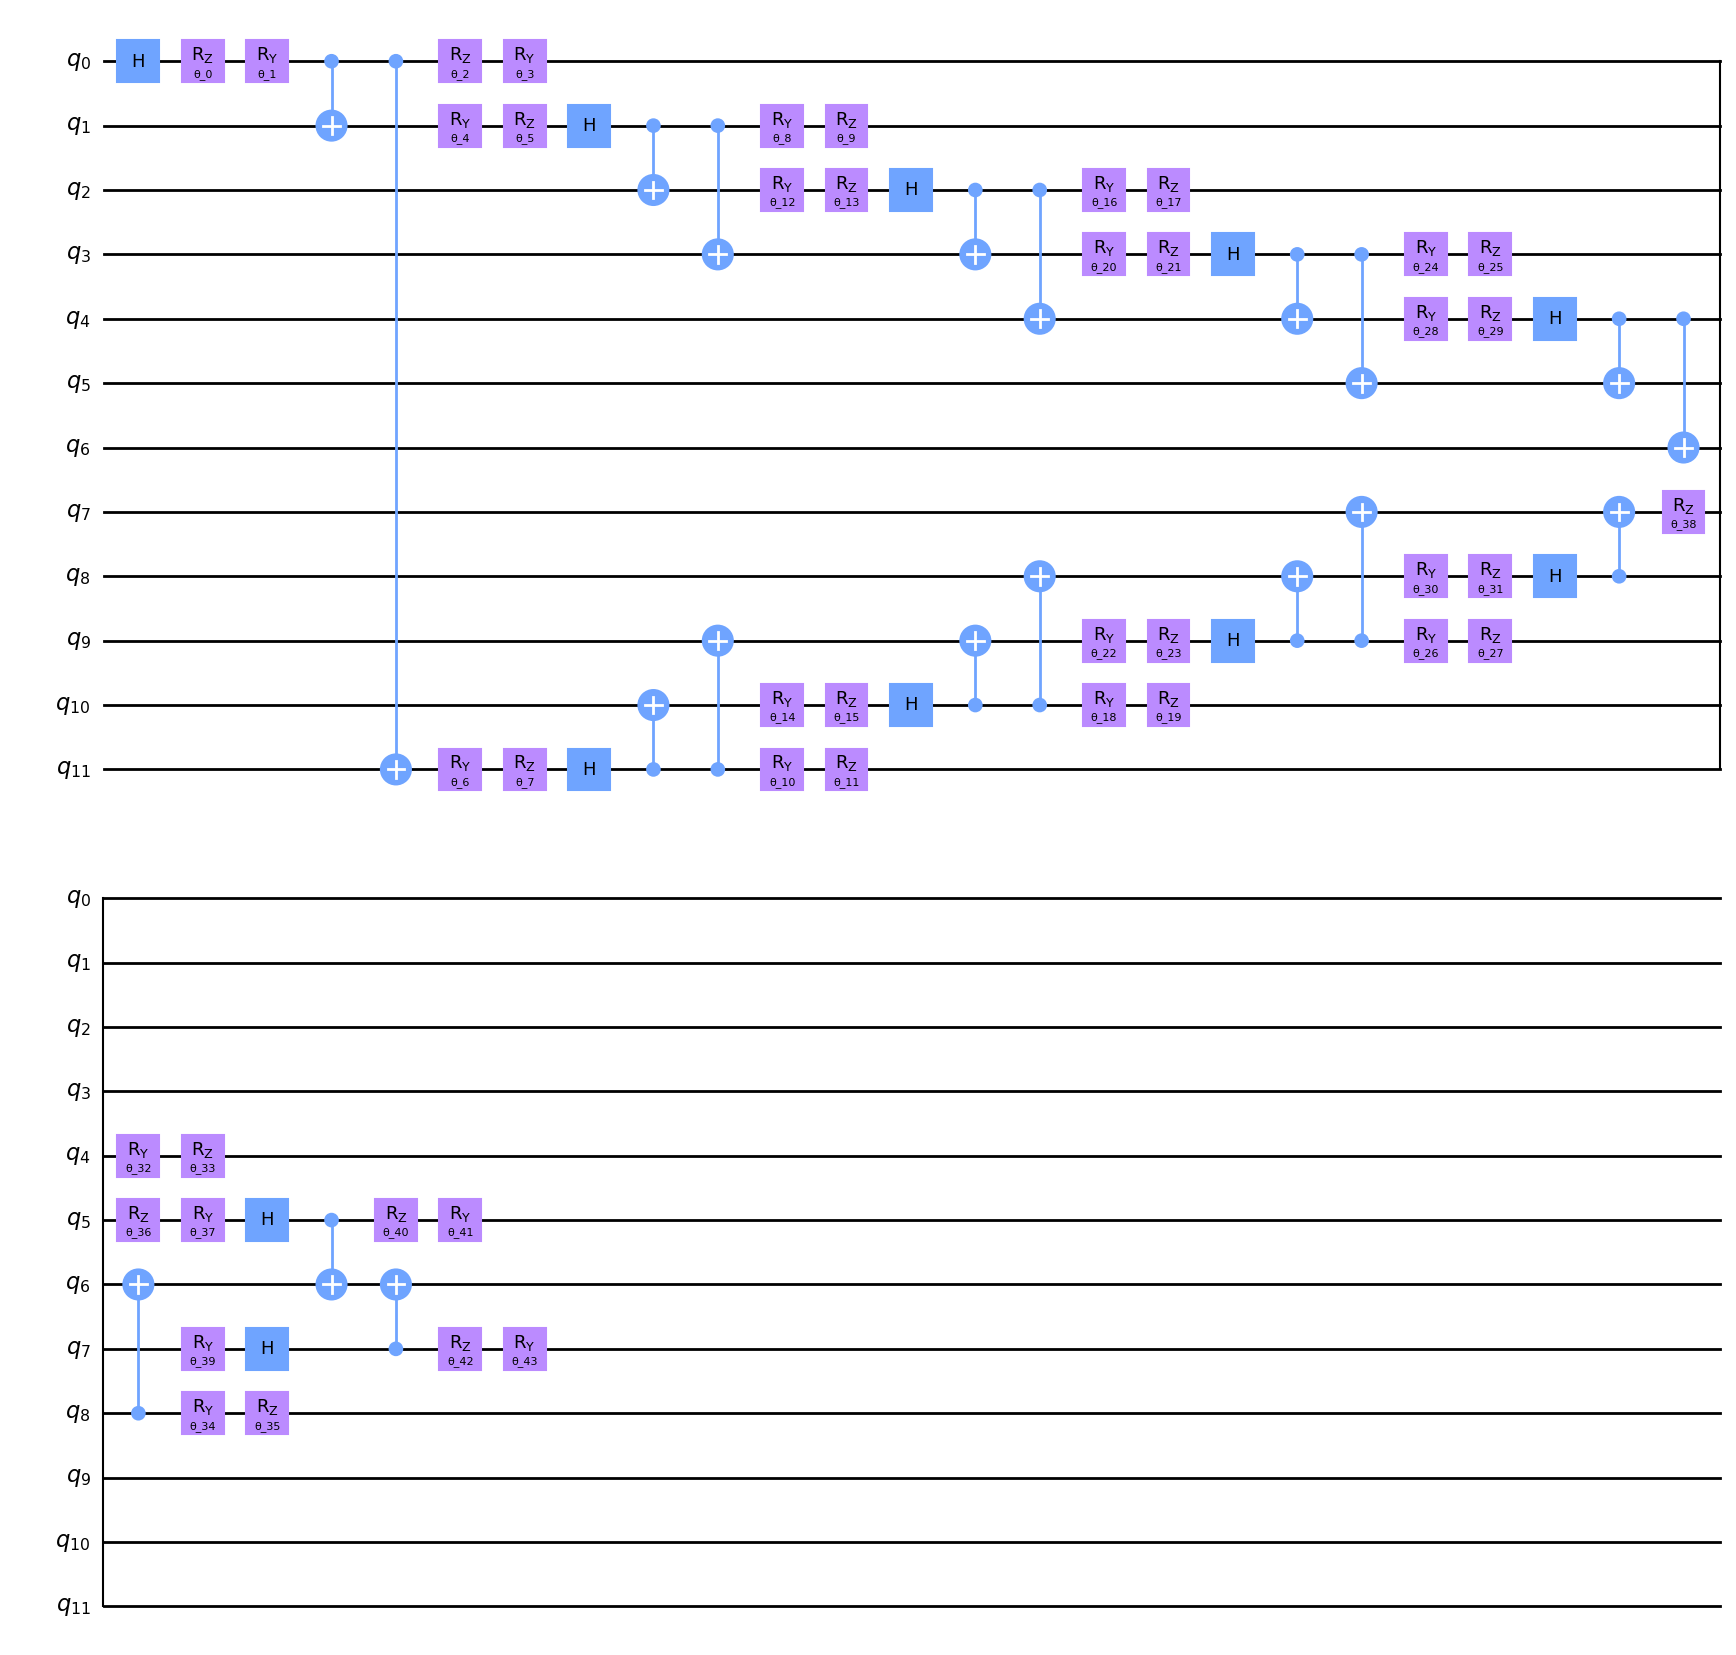

In [7]:
# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)
# Map two sets of edge traversals to use in the algorithm
edge_list_1 = [1, 2, 3, 4, 5, 6]
edge_list_2 = [11, 10, 9, 8, 7, 6]
ansatz_custom.h(0)
ansatz_custom.rz(Parameter('θ_0'), 0)
ansatz_custom.ry(Parameter('θ_1'), 0)
ansatz_custom.cx(0,1)
ansatz_custom.cx(0,11)
ansatz_custom.rz(Parameter('θ_2'), 0)
ansatz_custom.ry(Parameter('θ_3'), 0)
j = 4
for i in range(4):
    ansatz_custom.ry(Parameter('θ_' + str(j)), edge_list_1[i])
    j+=1
    ansatz_custom.rz(Parameter('θ_' + str(j)), edge_list_1[i])
    j+=1
    ansatz_custom.ry(Parameter('θ_' + str(j)), edge_list_2[i])
    j+=1
    ansatz_custom.rz(Parameter('θ_' + str(j)), edge_list_2[i])
    j+=1
    ansatz_custom.h(edge_list_1[i])
    ansatz_custom.cx(edge_list_1[i], edge_list_1[i+1])
    ansatz_custom.cx(edge_list_1[i], edge_list_1[i+2])
    ansatz_custom.ry(Parameter('θ_' + str(j)), edge_list_1[i])
    j+=1
    ansatz_custom.rz(Parameter('θ_' + str(j)), edge_list_1[i])
    j+=1
    ansatz_custom.h(edge_list_2[i])
    ansatz_custom.cx(edge_list_2[i], edge_list_2[i+1])
    ansatz_custom.cx(edge_list_2[i], edge_list_2[i+2])
    ansatz_custom.ry(Parameter('θ_' + str(j)), edge_list_2[i])
    j+=1
    ansatz_custom.rz(Parameter('θ_' + str(j)), edge_list_2[i])
    j+=1
ansatz_custom.rz(Parameter('θ_' + str(j)), 5)
j+=1
ansatz_custom.ry(Parameter('θ_' + str(j)), 5)
j+=1
ansatz_custom.h(5)
ansatz_custom.cx(5,6)
ansatz_custom.rz(Parameter('θ_' + str(j)), 7)
j+=1
ansatz_custom.ry(Parameter('θ_' + str(j)), 7)
j+=1
ansatz_custom.h(7)
ansatz_custom.cx(7,6)
ansatz_custom.rz(Parameter('θ_' + str(j)), 5)
j+=1
ansatz_custom.ry(Parameter('θ_' + str(j)), 5)
j+=1
ansatz_custom.rz(Parameter('θ_' + str(j)), 7)
j+=1
ansatz_custom.ry(Parameter('θ_' + str(j)), 7)
j+=1
# First layer
ansatz_custom.draw(output="mpl")

There are 3 key gates that are used: The Hadamard gate (H), the phase gates (Rx & Ry), and the CNOT gate connecting two qubits. Their purposes have been outlined below.

Hadamard gate: Also known as the entanglement gate. This gate mimics the behavior of an electron in a spin liquid having both spin polarities in the system

CNOT gate: Short for Controlled NOT gate. This gate will evaluate the two qubits connected together and will evaluate whether or not the spin polarities are the same. If the polarities are the same, one qubit will switch its polarity to the opposite polarity to satisfy the spin pairing.

Phase gate: These gates are established in order to mitigate any type of error the quantum circuit may encounter in the system.

Now that we've created that ansatz, we must adapt it to work on the Guadalupe computer

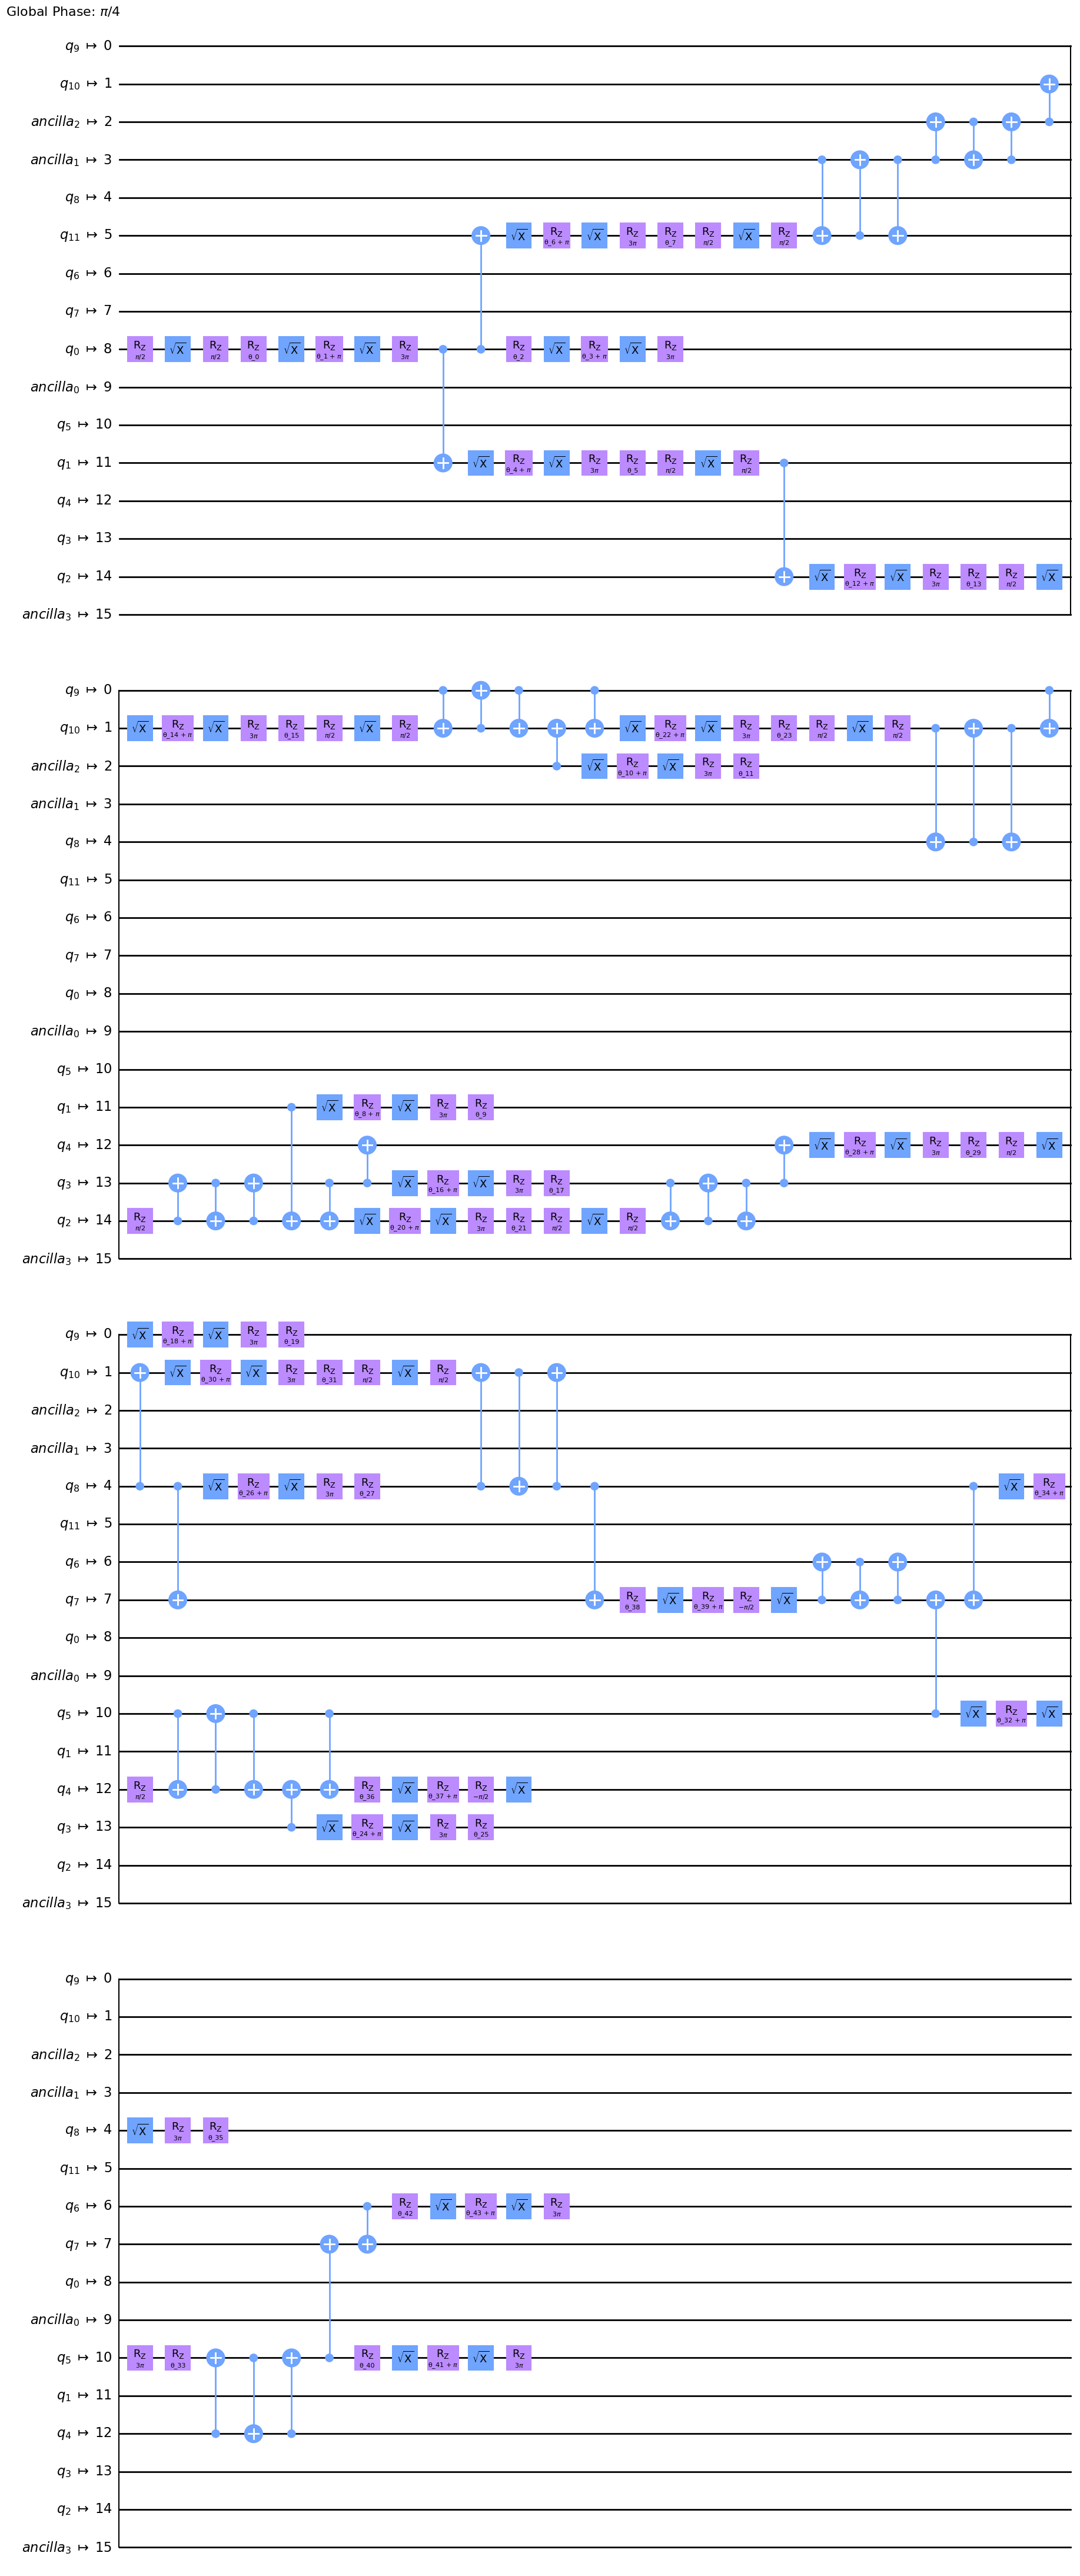

In [8]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
ansatz_opt = transpile(ansatz_custom, backend=noisy_sim)

ansatz_opt.draw(output="mpl")

We then must set the number of iterations we would like the VQE algorithm to operate at.

In [9]:
from qiskit.algorithms.optimizers import *

optimizer_dict = {'nft': NFT(maxiter=150)}

Additionally, we have set up a cutsom VQE algorithm to apply the variational method to otain the new Hamiltonian of the system

In [10]:

from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [12]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [13]:
from qiskit.primitives import Estimator

Finally, what's left is us to run the VQE algorithm with respect to our Ansatz, plot the upper bound relation, and find the relative error to our VQE calculation.

execution time (s): 43.79


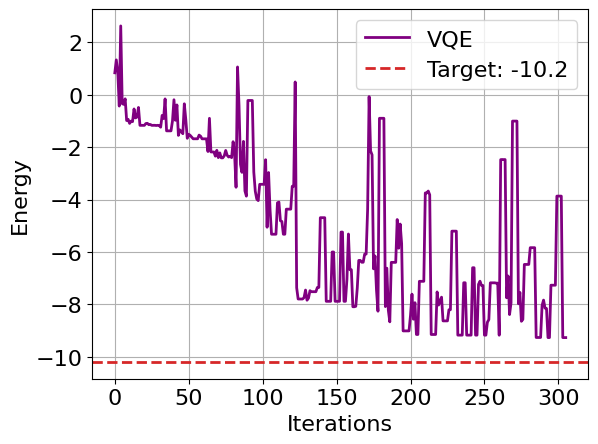

In [14]:
for optimizer in optimizer_dict:
    # Define instance of qiskit-terra's Estimator primitive
    estimator = Estimator([ansatz_opt], [ham_12])

    # Setup VQE algorithm
    custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer_dict[optimizer], callback=callback)

    # Run the VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(ham_12)
    end = time()

    print(f'execution time (s): {end - start:.2f}')

    # Plot settings for visulization
    plt.plot(intermediate_info, color='purple', lw=2, label="VQE")
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=-10.2, color="tab:red", ls="--", lw=2, label="Target: " + str(-10.2))
    plt.legend()
    plt.grid()
# Plot the data
plt.show()

In [15]:
def rel_err(target, measured):
    """
    Calculates the error between the ground state value
    and the calculated ground state value after using VQE

    Args:
        target: A float representing the given ground state of
        the lattice configuration
        measured: A float representing the computed value of the
        ground state after utilizing the VQE algorithm
    
    Returns:
        A float to represent the percent error between the target
        and computed ground state value
    """
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(-10.2, result.eigenvalue)

print(f'Expected ground state energy: {-10.2:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -10.2000000000
Computed ground state energy: -9.2710668693
Relative error: 0.09107188


As you can see, the ground state calculation that was found is pretty close to the actual stated ground state energy level. That being said, there are multiple different sources of errors that could have arisen based off of the way that we constructed our Ansatz. For example, we chose to neglect the quantum interaction between qubit 1 and 11 when they are both in the entangled state because they would likely have no effect on eachother because they are already entangled. We only modeled the quantum behavior of two electrons at the same time and evaluated the graph nodes two at a time instead of modeling them all simultaneously. We could attempt to get a more accurate modeling of our ansatz through analyzing the whole structure of the lattice such as taking a look at its geometric symmetries.